<a href="https://colab.research.google.com/github/VolkiTheDreamer/PythonRocks/blob/master/Machine%20Learning/Reinforcement%20Learning/Gym_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starters

In [ ]:
!pip -q install ipython-autotime
%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.4 MB/s eta 0:00:00
time: 318 µs (started: 2025-05-17 14:42:32 +00:00)


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

time: 521 µs (started: 2025-05-17 14:42:32 +00:00)


# Sıfırda manuel oluşturma

In [ ]:
import gymnasium as gym
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import random
import pickle
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

time: 8.43 s (started: 2025-05-17 14:42:32 +00:00)


(Medium yazısına link, after publish)

Environemnet hakkındaki detay bilgilere [buradan](https://gymnasium.farama.org/environments/classic_control/cart_pole/) ulaşabilrisiniz.

Ben tensorflow kullancağım. Torch ile örnek uygulama göremk isterseniz
[burada](https://github.com/ritakurban/Practical-Data-Science/blob/master/DQL_CartPole.ipynb) detaylı bir anlatım sözkonusu, bakılabilir veya aşağıdaki benim kodları kendiniz torch'a çevirmek isteyebilirsiniz, bunla da uğraşmak istemezseniz ChatGPT veya benzeri bir araca dönüşüm sağlatabilirsiniz. Ancak ben sıfırdan sizin manuel yazmanızı tavsiye ederim.  

## Ortak Kullanılacak Train ve Test fonksiyonları

Bu fonksiyonları tüm yöntemlerde kullanacağız, o yüzden en başa aldım ama bu kısmı şimdi atlayıp öncelikle Pure DQL kısmına gelin. Orayı inceledikten sonra bunlara tekrar bakarsınız.

Öncelikle klasik Q-Learningde kurguladığımız eğitim kodunu kodlayalım. Dıştaki for döngümüz episodelar için olacak, içteki while döngümüz ise ilgili episode bitene kadar sürekli devam edecek.

In [ ]:
def train_model(env, agent, episodes = 100, print_episode=True):
  scores = []
  for e in tqdm(range(episodes)):
      state,_ = env.reset()
      if printInsideTraining:
        print(f"state before reshape: {state}, shape: {state.shape}")

      state = state.reshape(1,-1)
      if printInsideTraining:
        print(f"state after reshape: {state}, shape: {state.shape}")

      sayac = 0
      while True:
          if printInsideTraining:
            print(f"\nsayac:{sayac}")
          if agent is None:
            action = env.action_space.sample()
          else:
            action = agent.choose_action(state)
          if printInsideTraining:
              print(f"seçilen action:{action}")
          # bu action'a göre hareket edelim
          next_state, reward, terminated, truncated , _= env.step(action) #son parametre info olup gereksizdir
          done = terminated or truncated
          if printInsideTraining:
              print(f"nextstate before reshape:{next_state} ve shape'i: {next_state.shape}")

          next_state = next_state.reshape(1,-1)
          if printInsideTraining:
              print(f"nextstate after reshape:{next_state} ve shape'i: {next_state.shape}")
          if agent is not None:
            # yeni edindiğimiz deneyimi hafızaya atalım
            agent.add_experince_to_memory(state, action, reward, next_state, done)
          # state'i güncelleyelim
          state = next_state

          if agent is not None:
            # eğitimi tamamlayalım
            agent.replay_vectorized() #T4 GPU'da 100 episodes 13 dk, vectorize olmayan metod 9 saat sürdü
          if agent is not None:
            # epsilon'ı güncelleyelim
            if agent.epsilon > agent.epsilon_min:
                agent.epsilon *= agent.epsilon_decay
          #sayacı 1 artıralım
          sayac += 1
          if done:
              if print_episode:
                print(f"Episode: {e}, sayaç: {sayac}")
              scores.append(sayac)
              break
  plt.plot(scores)
  plt.axhline(np.mean(scores), color='red', linestyle='dashed')
  _, max_xlim = plt.xlim()
  plt.text(max_xlim*1.01, np.mean(scores)*0.99, f'Ortalama: {np.mean(scores):.1f}')
  plt.text(np.argmax(scores)*1.01, np.max(scores)*0.99, f'Max: {np.max(scores):.1f}')

  thresh = 500
  plt.axhline(thresh, color='blue')
  plt.text(max_xlim*1.01, thresh*0.99, f'Kazanma eşik noktası:{thresh}')
  plt.show();

time: 2.07 ms (started: 2025-05-17 14:42:48 +00:00)


In [ ]:
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
def test_model(env, trained_agent, n):
  #n kez oynasın

  scores=[]
  for i in tqdm(range(n)):
    state ,_= env.reset()
    state = state.reshape(1,-1)
    sayac = 0
    while True:
        if trained_agent is not None:
          action = trained_agent.choose_action(state)
        else:
          action = env.action_space.sample()
        next_state, reward, terminated, truncated ,_= env.step(action)
        done = terminated or truncated
        next_state = next_state.reshape(1,-1)
        state = next_state
        sayac += 1
        if done:
            break
    print(f"{i}. oyunda {sayac} hamle dayandı")
    scores.append(sayac)

  print(f"Ortalama dayanma süresi:{np.mean(scores)} hamle")
  print(f'Episode time taken: {env.time_queue}')
  print(f'Episode total rewards: {env.return_queue}')
  print(f'Episode lengths: {env.length_queue}')
  env.close()

time: 1.26 ms (started: 2025-05-17 14:42:49 +00:00)


In [ ]:
import base64
from IPython.display import HTML
import moviepy.editor as mpy

def show_video(video_path, slow_factor=None):
  if slow_factor is not None:
    clip = mpy.VideoFileClip(video_path)
    slow_motion_clip = clip.fx(mpy.vfx.speedx, 1/slow_factor)
    slow_motion_clip.write_videofile(f"{video_path[:-4]}_sw.mp4")
    video = open(f"{video_path[:-4]}_sw.mp4", 'rb').read()
  else:
    video = open(video_path, 'rb').read()
  encoded = base64.b64encode(video)
  return HTML(data='''<video alt="test" autoplay
                controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

def save_as_gif(video_path):
  clip = mpy.VideoFileClip(video_path)
  clip.write_gif(f"{video_path[:-4]}.gif")

  if event.key is 'enter':



time: 605 ms (started: 2025-05-17 14:42:50 +00:00)


## Random action stratejisi

  0%|          | 0/100 [00:00<?, ?it/s]

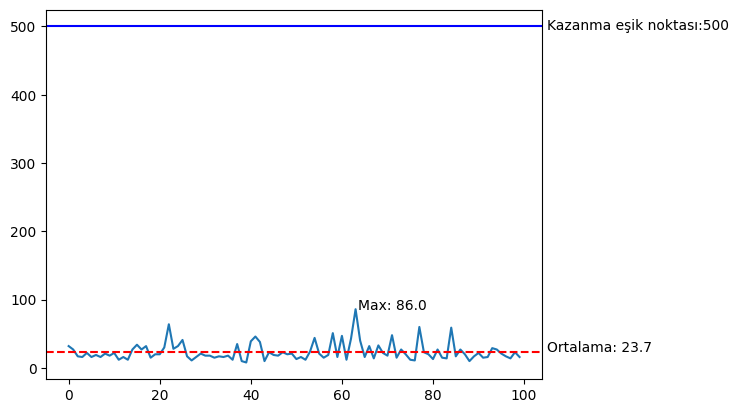

time: 685 ms (started: 2025-05-13 17:44:42 +00:00)


In [ ]:
env = gym.make("CartPole-v1") #env'i yaratalım
printInsideTraining=False
train_model(env, agent = None, episodes=100, print_episode=False)

In [ ]:
# test
num_eval_episodes = 10
env = gym.make("CartPole-v1", render_mode="rgb_array")
env = RecordVideo(env, video_folder="cartpole-agent", name_prefix="random-test",
                  episode_trigger=lambda x: True)
env = RecordEpisodeStatistics(env, buffer_length=num_eval_episodes)
test_model(env, None, n=num_eval_episodes)

  0%|          | 0/10 [00:00<?, ?it/s]

0. oyunda 11 hamle dayandı
1. oyunda 11 hamle dayandı
2. oyunda 43 hamle dayandı
3. oyunda 17 hamle dayandı
4. oyunda 35 hamle dayandı
5. oyunda 17 hamle dayandı
6. oyunda 11 hamle dayandı
7. oyunda 38 hamle dayandı
8. oyunda 11 hamle dayandı
9. oyunda 20 hamle dayandı
Ortalama dayanma süresi:21.4 hamle
Episode time taken: deque([0.028161, 0.030369, 0.123758, 0.04601, 0.078374, 0.047949, 0.027105, 0.10018, 0.029851, 0.05549], maxlen=10)
Episode total rewards: deque([11.0, 11.0, 43.0, 17.0, 35.0, 17.0, 11.0, 38.0, 11.0, 20.0], maxlen=10)
Episode lengths: deque([11, 11, 43, 17, 35, 17, 11, 38, 11, 20], maxlen=10)
time: 1.81 s (started: 2025-05-13 17:44:47 +00:00)


In [ ]:
show_video('cartpole-agent/random-test-episode-0.mp4', slow_factor=5)

Moviepy - Building video cartpole-agent/random-test-episode-0_sw.mp4.
Moviepy - Writing video cartpole-agent/random-test-episode-0_sw.mp4



Moviepy - Done !
Moviepy - video ready cartpole-agent/random-test-episode-0_sw.mp4


time: 513 ms (started: 2025-05-13 17:44:57 +00:00)


## Pure DQL

In [ ]:
class DQLAgent:
    def __init__(self, env, loss="mse",batch_size=16,learning_rate=0.001,memory_size=1000):
        # bu class'tan bir obje yaratıldığında set edilecek değerler ve çalıştırılacak metodlar
        self.state_size = env.observation_space.shape[0] #4
        self.action_size = env.action_space.n #2
        self.gamma = 0.95
        self.learning_rate = learning_rate
        self.epsilon = 1  # explore
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.memory = deque(maxlen = memory_size) #replay meomry hacmi
        self.verbose = False
        self.batch_size= batch_size

        self.online_model = self.build_model(loss) # sadece Q networkünü oluşturuyoruz

    def save(self, file):
        pickle.dump(self, open(file, "wb"))

    def build_model(self, loss):
        model = Sequential()
        model.add(Dense(24, input_dim = self.state_size, activation = "relu")) #Ideal senaryoda node adedi tune edilebilir, biz şuan buna takılmayacağız, 48 sabit kalsın
        model.add(Dense(48, input_dim = self.state_size, activation = "relu")) #bu araya tercihe göre bir katman daha eklenebilir
        model.add(Dense(self.action_size, activation = "linear")) #output layer'ımızda action adedi kadar node olacak
        model.compile(loss = loss, optimizer = Adam(learning_rate = self.learning_rate))
        return model

    def add_experince_to_memory(self, state, action, reward, next_state, done):
        # deneyimleri hafızaya atıyoruz, sonra buradan random kayıt seçceğiz
        self.memory.append((state, action, reward, next_state, done))
        if self.verbose:
            print(f"replay memory hacmi:{len(self.memory)}")

    def choose_action(self, state):
        # acting: explore or exploit
        if random.uniform(0,1) <= self.epsilon:
            return env.action_space.sample()
        else:
            act_values = self.online_model.predict(state, verbose=0)
            return np.argmax(act_values[0])

    def _replay(self): #*********************************************************DİKKAT: Kullanılmayacak, alttaki açıklamayı okuyun******************************************************
        # öğrenemyi sağlayan metoddur. adını train veya learn olarak da değiştirebiliriz
        # birçok blogda/eğitimde replay metodu bu şekilde kodlanır ama buradaki for döngüsü çalışma süresi açısından efektif değildir, biz bi alttaki vektörize halini kullanacağız
        # rakamsal örnek vermek gerekirse, T4 FPU'da, 100 episode için çalışması 9 saat sürerken, vectorized olan 15 dk sürmüştür
        if len(self.memory) < self.batch_size: #agent'ın hafızasında yeterince deneyim yoksa devam etmeyelim, deneyim biriktirmeye devam edelim
            return
        minibatch = random.sample(self.memory,self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            if done:
                target = reward
            else:
                target = reward + self.gamma*np.amax(self.online_model.predict(next_state, verbose=0)[0])
            train_target = self.online_model.predict(state, verbose=0)
            train_target[0][action] = target
            #1 epoch ile eğitilmesinin nedeni, online öğrenme, kararlılık, verimlilik ve deneyim tekrarı tekniklerinin etkinliğini en üst düzeye çıkarmaktır.
            #Bu, modelin yeni bilgilere hızlı bir şekilde uyum sağlamasına, öğrenme sürecini stabilize etmesine, eğitim süresini azaltmasına ve aşırı uyum sağlamasını önlemeye yardımcı olur.
            self.online_model.fit(state,train_target, epochs=1, verbose = 0)

    def replay_vectorized(self):
        # üstteki metodun vektörize halidir
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory,self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch) # [(1, 2, 3, 4, 5), (10, 20, 30, 40, 50)] gibi bir listeyi [(1, 10,.....), (2, 20,......), (3, 30,.......), (4, 40,.......), (5, 50,......)] haline çeviriyoruz, ki bunları numpy diziye çevirebilelim
        if self.verbose:
          print(f"states before numpy dönüşüm in replay metodu:{states}")
        # numpy array'e çevrielim
        self.states = np.array(states)
        self.actions = np.array(actions)
        self.rewards = np.array(rewards)
        self.next_states = np.array(next_states)
        self.dones = np.array(dones)

        if self.verbose:
          print(f"states before reshape in replay:{self.states}, states.shape:{self.states.shape}")
        self.states = self.states.reshape(self.batch_size, self.state_size)  #  (16,1,4) olan shape'i (16,4) yapıyoruz

        if self.verbose:
          print(f"states after reshape in replay:{self.states},states.shape:{self.states.shape}")

        self.next_states = self.next_states.reshape(self.batch_size, self.state_size)
        self.do_calculation() #normalde bunu ayrı metodu yapmaya gerek yoktu ama üst kısmı başka yerde de kullanacağımız için modüler hale getiriyorum

    def do_calculation(self):
        q_expected = self.online_model.predict(self.states, verbose=0) #mevcut statelerden Q-valueları tahminleme yapalım, Q(s,a)
        if self.verbose:
          print(f"q_expected:{q_expected}")

        q_next_target = self.online_model.predict(self.next_states, verbose=0)  # next statelerden Q(s',a') tahminleyelim.
        if self.verbose:
          print(f"q_next:{q_next_target}")

        max_next_q = np.max(q_next_target, axis=1) # q_next_target içindeki en yüksek Q-value'larını alalım
        if self.verbose:
          print(f"max_next_q:{max_next_q}")

        q_targets = self.rewards + self.gamma * max_next_q * (1 - self.dones) #target Q-values hesabı
        if self.verbose:
          print(f"q_targets:{q_targets}")

        # Hangi aksiyon seçildiyse q_expectedda bu aksiyonu targetta ki ile update edelim
        # for idx, action in enumerate(actions):
        #     q_expected[idx][action] = q_targets[idx]
        q_expected[np.arange(self.batch_size), self.actions] = q_targets #vectorized olarak
        if self.verbose:
          print(f"q_expected after update:{q_expected}")

        # eğitelim
        self.online_model.fit(self.states, q_expected, epochs=1, verbose=0)
        self.verbose = False #sadece bir kez bastırmak yeterli bence. Tümünü bastırmak isteyen commentleyebilir


time: 2.12 ms (started: 2025-05-17 14:42:54 +00:00)


Şimdi agentımızı yaratıp eğitelim.

  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  0%|          | 0/200 [00:00<?, ?it/s]

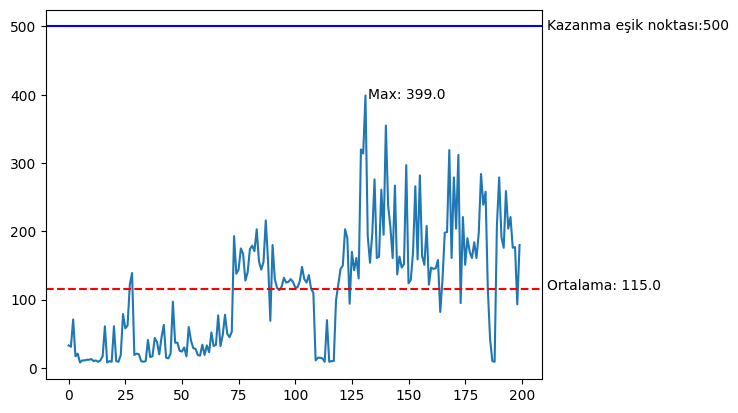

time: 1h 55min 15s (started: 2025-05-13 17:45:06 +00:00)


In [ ]:
env = gym.make("CartPole-v1") #env'i yaratalım
dqlagent = DQLAgent(env) #agent objesini yaratalım, init metodu tetiklenecek
# agent.verbose = True #Uncomment yaparak repaly metodu içindeki print'li kısımların görünmesini sağlayabilirsiniz
printInsideTraining = False # T/F yaparak bu hücre içindeki printlerin görünüp görünmemesini sağlayabilirsiniz
# kodda kalabalık odluğunu düşünüyorsanız ve print'lere gerek duymuyorsanız o satırları silebilirsiniz

train_model(env, dqlagent, episodes=200, print_episode=False) #ilk 100 civarını hızlı öğreniyor ama yeterli öğrenme olmadığı için hızlı oluyr, sonra yavaş yaval güzel öğreniyor, daha uzun sürüyor

110-120'den sonra güzel öğrenmiş gibi. yüksek skorlara ulaşıp sonra tekrar düşmesinin en büyük sebebi, ar ara keşif yapmaya devam etmesi olarak düşünülebilir.

In [ ]:
#agent'ımızı sonraki kullanımları için kaydedelim
dqlagent.save("dqlagent.pkl")

time: 46.2 ms (started: 2025-05-13 19:53:12 +00:00)


In [ ]:
# test
num_eval_episodes = 10
env_test = gym.make("CartPole-v1", render_mode="rgb_array")
env_test = RecordVideo(env_test, video_folder="cartpole-agent", name_prefix="dql-test",
                  episode_trigger=lambda x: True)
env_test = RecordEpisodeStatistics(env_test, buffer_length=num_eval_episodes)
trained_agent = pickle.load(open("dqlagent.pkl", "rb"))
test_model(env_test, trained_agent, n=num_eval_episodes)

  logger.warn(



  0%|          | 0/10 [00:00<?, ?it/s]

0. oyunda 237 hamle dayandı
1. oyunda 183 hamle dayandı
2. oyunda 187 hamle dayandı
3. oyunda 174 hamle dayandı
4. oyunda 178 hamle dayandı
5. oyunda 191 hamle dayandı
6. oyunda 403 hamle dayandı
7. oyunda 287 hamle dayandı
8. oyunda 317 hamle dayandı
9. oyunda 327 hamle dayandı
Ortalama dayanma süresi:248.4 hamle
Episode time taken: deque([17.288758, 13.620257, 13.939106, 12.857673, 13.119102, 14.499922, 29.635381, 21.05372, 23.490904, 24.602627], maxlen=10)
Episode total rewards: deque([237.0, 183.0, 187.0, 174.0, 178.0, 191.0, 403.0, 287.0, 317.0, 327.0], maxlen=10)
Episode lengths: deque([237, 183, 187, 174, 178, 191, 403, 287, 317, 327], maxlen=10)
time: 3min 12s (started: 2025-05-13 19:53:33 +00:00)


In [ ]:
show_video('cartpole-agent/dql-test-episode-0.mp4')

time: 2.85 ms (started: 2025-05-13 19:56:58 +00:00)


## DQN

Şimdi DQNAgent adında bir class yaratacağız. Bu, birçok açıdan DQLAgent'a benzeyecek, herşeyi tekrar tekrar kodlamak yerine DQLAgent'ı inherit eden bir class yaratalım ve sadece replay metodunu override edelim.

In [ ]:
class DQNAgent(DQLAgent):
    def __init__(self, env, loss="mse", batch_size=16, learning_rate=0.001, memory_size=1000, target_update=50):
        super().__init__(env, loss, batch_size, learning_rate, memory_size)
        #DQLAgent'a ek olarak şunları yapalım

        # modelleri oluşturalım
        self.online_model   = self.build_model(loss)
        self.target_model   = self.build_model(loss)
        self.target_model.set_weights(self.online_model.get_weights())  # Başlangıçta ağırlıkları eşitleyelim
        self.target_update  = target_update #her 50 updatede güncelleme oalcak, tune edilebilir. çok yüksek seçilirse, hiç update edemeden oyun sonlanabilir, küçük sayılar seçilmeli
        self.update_counter = 0


    def do_calculation(self):
        # 1) Target Q’ları hesapla (target newotrk üzerinden)
        q_next_target = self.target_model.predict(self.next_states, verbose=0)   # Target ağdan next Q’ları al
        max_next_q    = np.max(q_next_target, axis=1)                       # en büyük değeri seç
        q_targets      = self.rewards + self.gamma * max_next_q * (1 - self.dones)
        if self.verbose:
          print(f"q_next_target:{q_next_target}")

        self.continue_calculation(q_targets) #bu kısmı aynen double DQN'de de kullanacağımız için ayırdık, sadece üst kısım değişecek.


    def continue_calculation(self,q_targets):
        # 2) Online ağdan mevcut Q tahminlerini al
        q_expected = self.online_model.predict(self.states, verbose=0)

        # 3) Sadece seçilen aksiyonun Q’sunu güncelle
        q_expected[np.arange(self.batch_size), self.actions] = q_targets

        # 4) Bu batch’ten öğren
        self.online_model.fit(self.states, q_expected, epochs=1, verbose=0)

        # 5) Target ağı periyodik güncelle
        self.update_counter += 1
        if self.update_counter % self.target_update == 0:
            self.target_model.set_weights(self.online_model.get_weights())
            if self.verbose:
              print(f"Updating target network at step {self.update_counter}")

        self.verbose = False #sadece bir kez bastırmak yeterli bence. Tümünü bastırmak isteyen commentleyebilir



time: 1.11 ms (started: 2025-05-17 14:49:49 +00:00)


  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



  0%|          | 0/200 [00:00<?, ?it/s]

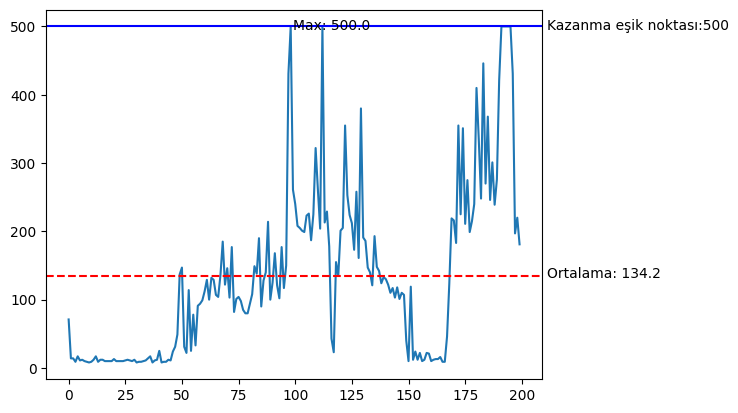

time: 2h 9min 6s (started: 2025-05-13 20:02:51 +00:00)


In [ ]:
env = gym.make("CartPole-v1")
dqnagent = DQNAgent(env) #DQL'den farklı olarak sadece burayı değiştriyirouz
# agent.verbose = True #Uncomment yaparak repaly metodu içindeki print'li kısımların görünmesini sağlayabilirsiniz
printInsideTraining = False # T/F yaparak bu hücre içindeki printlerin görünüp görünmemesini sağlayabilirsiniz
# kodda kalabalık odluğunu düşünüyorsanız ve print'lere gerek duymuyorsanız o satırları silebilirsiniz

train_model(env, dqnagent,episodes=200, print_episode=False) #ilk 100 civarında çok hızlı ilerledi, 15 dk gibi, sonra hızlı öğrenmeye başladı ve eğitim süresi uzadı

In [ ]:
dqnagent.save("dqnagent.pkl")

time: 53.8 ms (started: 2025-05-13 22:11:58 +00:00)


In [ ]:
# test
num_eval_episodes = 10
env_test = gym.make("CartPole-v1", render_mode="rgb_array")
env_test = RecordVideo(env_test, video_folder="cartpole-agent", name_prefix="dqn-test",
                  episode_trigger=lambda x: True)
env_test = RecordEpisodeStatistics(env_test, buffer_length=num_eval_episodes)
trained_agent = pickle.load(open("dqnagent.pkl", "rb"))

  logger.warn(

  saveable.load_own_variables(weights_store.get(inner_path))



time: 145 ms (started: 2025-05-13 22:11:58 +00:00)


In [ ]:
test_model(env_test, trained_agent, n=num_eval_episodes)

  0%|          | 0/10 [00:00<?, ?it/s]

0. oyunda 193 hamle dayandı
1. oyunda 203 hamle dayandı
2. oyunda 194 hamle dayandı
3. oyunda 196 hamle dayandı
4. oyunda 195 hamle dayandı
5. oyunda 192 hamle dayandı
6. oyunda 193 hamle dayandı
7. oyunda 200 hamle dayandı
8. oyunda 196 hamle dayandı
9. oyunda 191 hamle dayandı
Ortalama dayanma süresi:195.3 hamle
Episode time taken: deque([13.497718, 14.118302, 13.304091, 13.866748, 13.704186, 13.063462, 13.25815, 14.62499, 14.413713, 13.889875], maxlen=10)
Episode total rewards: deque([193.0, 203.0, 194.0, 196.0, 195.0, 192.0, 193.0, 200.0, 196.0, 191.0], maxlen=10)
Episode lengths: deque([193, 203, 194, 196, 195, 192, 193, 200, 196, 191], maxlen=10)
time: 2min 17s (started: 2025-05-13 22:12:20 +00:00)


In [ ]:
show_video('cartpole-agent/dqn-test-episode-0.mp4')

FileNotFoundError: [Errno 2] No such file or directory: 'cartpole-agent/dqn-test-episode-0.mp4'

time: 261 ms (started: 2025-05-13 22:15:09 +00:00)


### Hyperparameter tuning

Tüm hyperparamtreleri değil de sadece birkaçı için deneme yapacağım, Bunların dışında
- loss olarak huber denedim ve başarsı düşük çıktığı için burada ele almıyorum
- Belki bir de optimizasyon yöntemi olarak farklı bişey denenebilir
- Activation olarak da tanh ve leaky relu da denenebilir.

ancak eğitim süresini çok daha fazla artırmak istemediğim için bunları yapmıyorum.

In [ ]:
from sklearn.model_selection import ParameterGrid
param_grid = {'update': [5,10,20,40,80],
              "batch_size":[32,64],
              "lr":[0.0001,0.005],
              "memory_size":[2000,5000,10000]
              }

time: 244 ms (started: 2025-05-14 10:43:42 +00:00)


{'batch_size': 32, 'lr': 0.0001, 'memory_size': 2000, 'update': 5}


  0%|          | 0/150 [00:00<?, ?it/s]

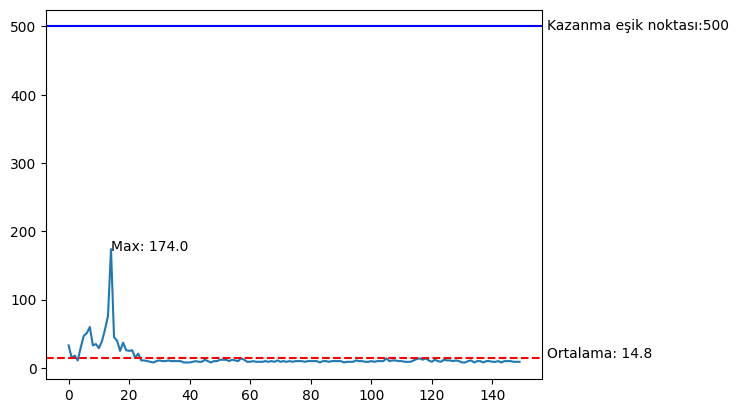

{'batch_size': 32, 'lr': 0.0001, 'memory_size': 2000, 'update': 10}


  0%|          | 0/150 [00:00<?, ?it/s]

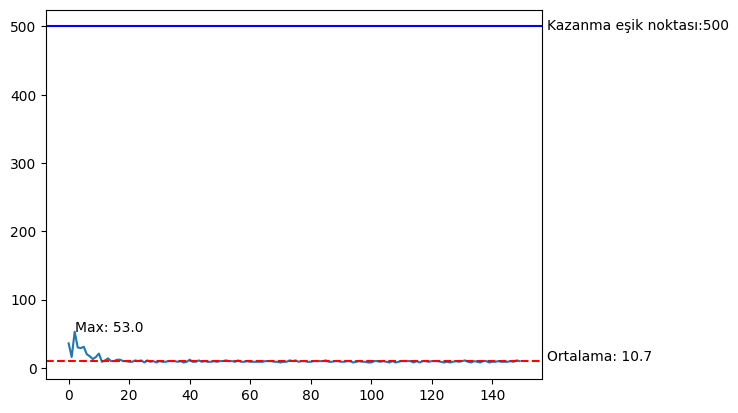

{'batch_size': 32, 'lr': 0.0001, 'memory_size': 2000, 'update': 20}


  0%|          | 0/150 [00:00<?, ?it/s]

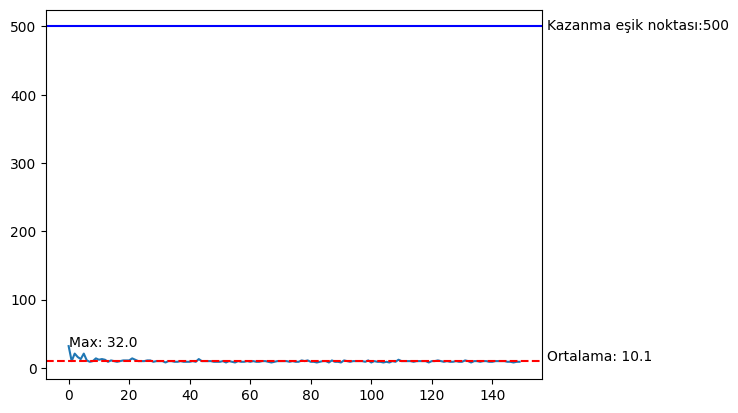

{'batch_size': 32, 'lr': 0.0001, 'memory_size': 2000, 'update': 40}


  0%|          | 0/150 [00:00<?, ?it/s]

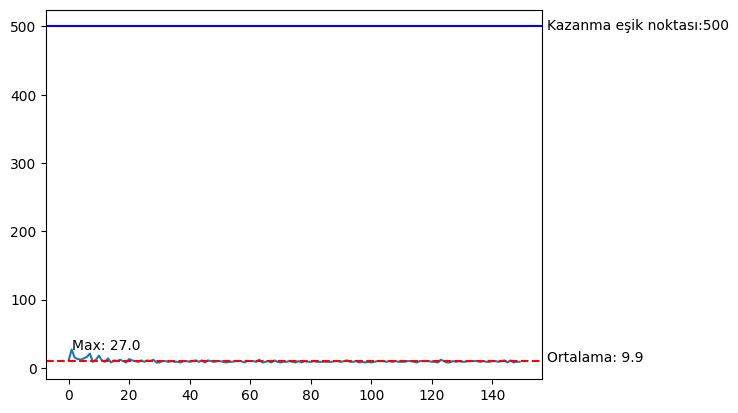

{'batch_size': 32, 'lr': 0.0001, 'memory_size': 2000, 'update': 80}


  0%|          | 0/150 [00:00<?, ?it/s]

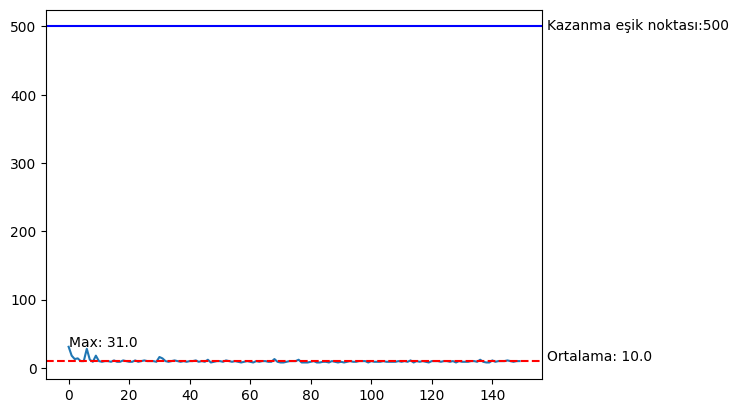

{'batch_size': 32, 'lr': 0.0001, 'memory_size': 5000, 'update': 5}


  0%|          | 0/150 [00:00<?, ?it/s]

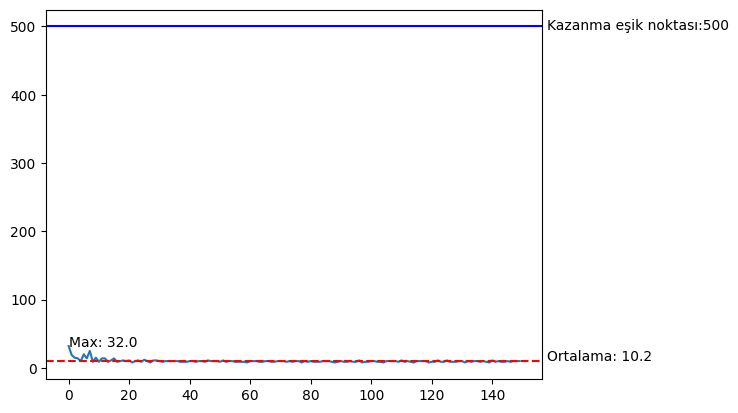

{'batch_size': 32, 'lr': 0.0001, 'memory_size': 5000, 'update': 10}


  0%|          | 0/150 [00:00<?, ?it/s]

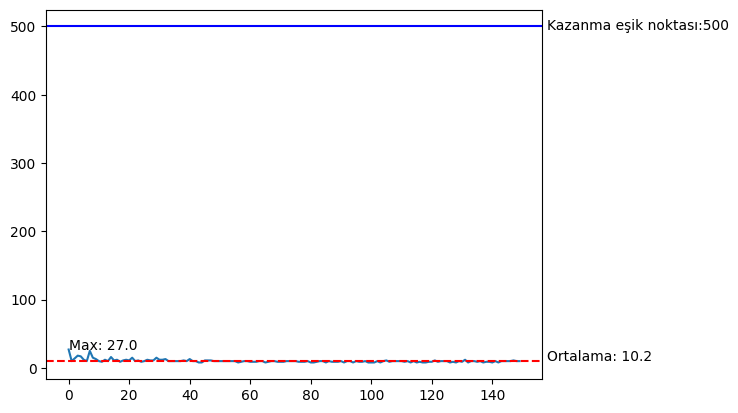

{'batch_size': 32, 'lr': 0.0001, 'memory_size': 5000, 'update': 20}


  0%|          | 0/150 [00:00<?, ?it/s]

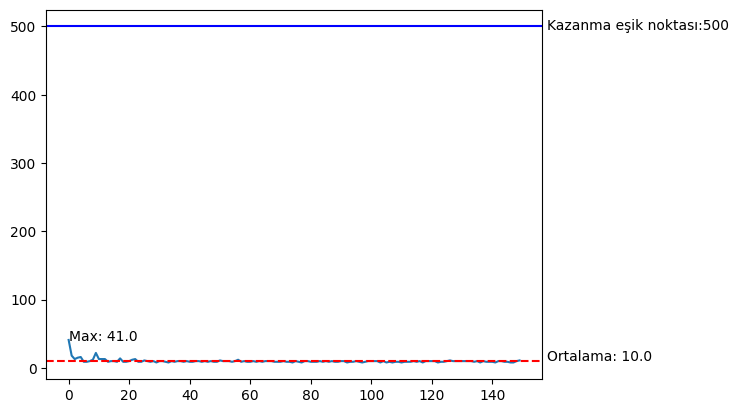

{'batch_size': 32, 'lr': 0.0001, 'memory_size': 5000, 'update': 40}


  0%|          | 0/150 [00:00<?, ?it/s]

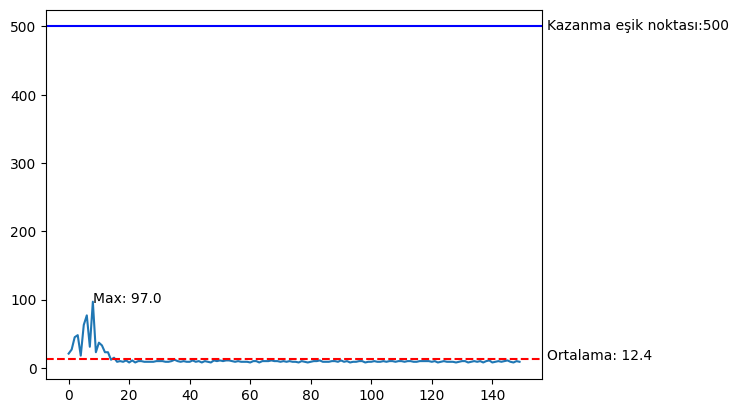

{'batch_size': 32, 'lr': 0.0001, 'memory_size': 5000, 'update': 80}


  0%|          | 0/150 [00:00<?, ?it/s]

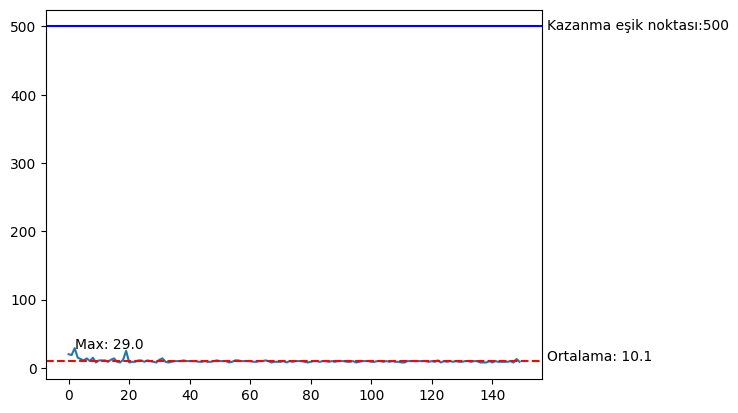

{'batch_size': 32, 'lr': 0.0001, 'memory_size': 10000, 'update': 5}


  0%|          | 0/150 [00:00<?, ?it/s]

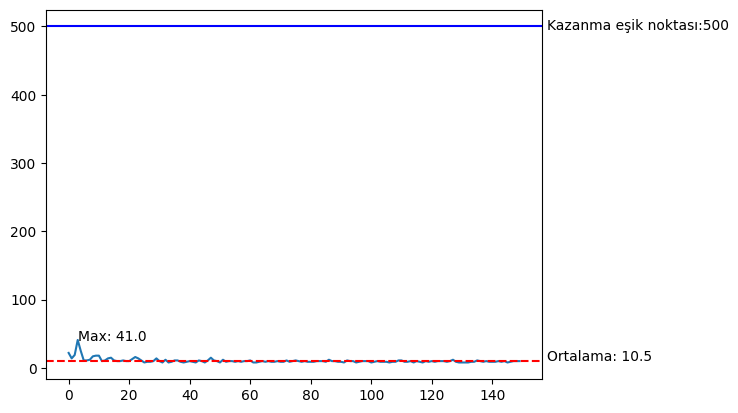

{'batch_size': 32, 'lr': 0.0001, 'memory_size': 10000, 'update': 10}


  0%|          | 0/150 [00:00<?, ?it/s]

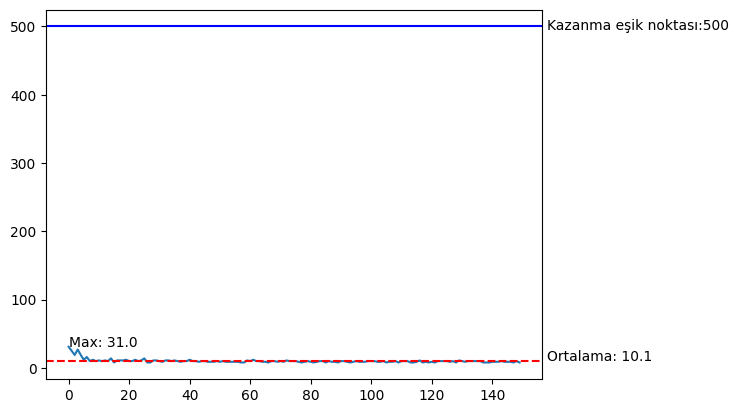

{'batch_size': 32, 'lr': 0.0001, 'memory_size': 10000, 'update': 20}


  0%|          | 0/150 [00:00<?, ?it/s]

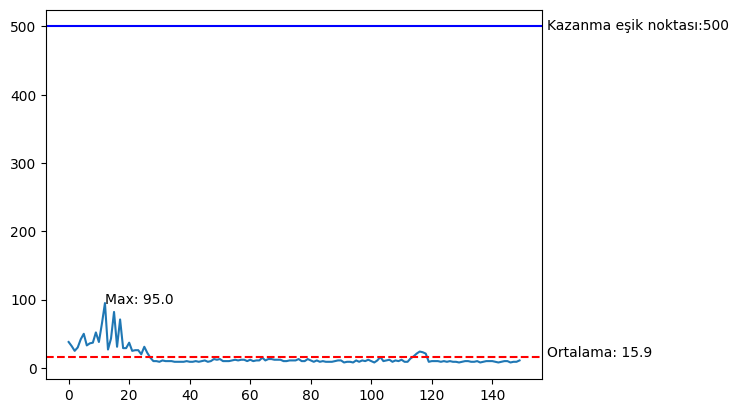

{'batch_size': 32, 'lr': 0.0001, 'memory_size': 10000, 'update': 40}


  0%|          | 0/150 [00:00<?, ?it/s]

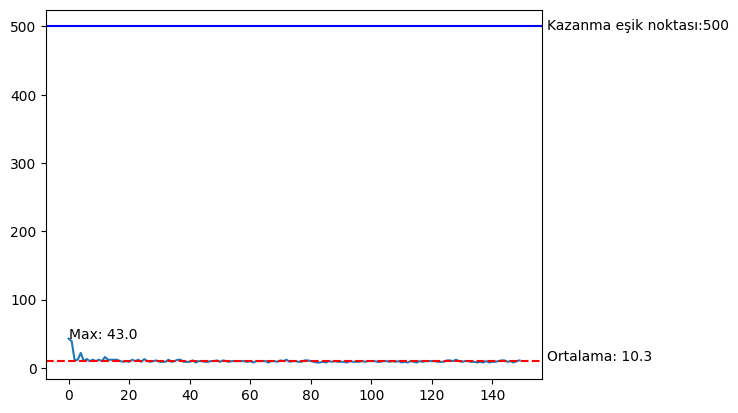

{'batch_size': 32, 'lr': 0.0001, 'memory_size': 10000, 'update': 80}


  0%|          | 0/150 [00:00<?, ?it/s]

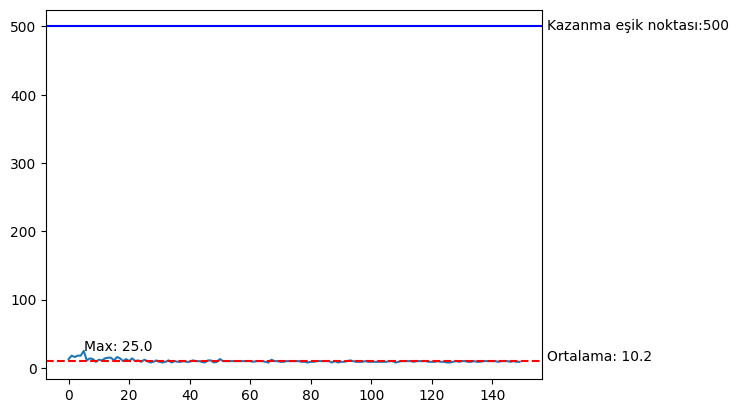

{'batch_size': 32, 'lr': 0.005, 'memory_size': 2000, 'update': 5}


  0%|          | 0/150 [00:00<?, ?it/s]

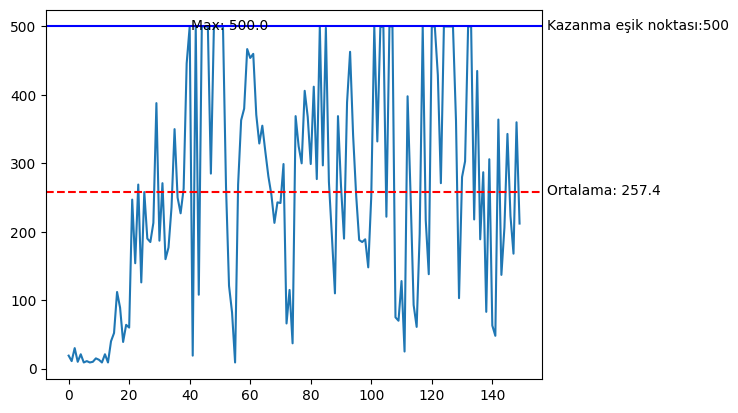

{'batch_size': 32, 'lr': 0.005, 'memory_size': 2000, 'update': 10}


  0%|          | 0/150 [00:00<?, ?it/s]

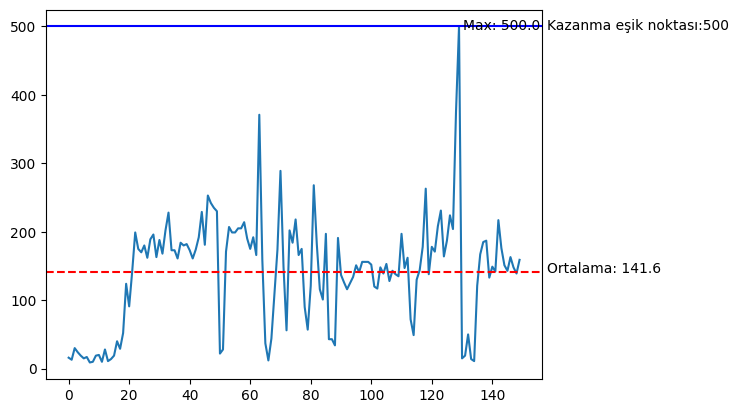

{'batch_size': 32, 'lr': 0.005, 'memory_size': 2000, 'update': 20}


  0%|          | 0/150 [00:00<?, ?it/s]

Exception ignored in: <function _xla_gc_callback at 0x7f86b413e160>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


KeyboardInterrupt: 

time: 6h 47min 38s (started: 2025-05-14 10:44:09 +00:00)


In [ ]:
for e,params in enumerate(ParameterGrid(param_grid)):
  print(params)
  env = gym.make("CartPole-v1")
  dqnagent = DQNAgent(env,"mse",params["batch_size"],params["lr"],params["memory_size"],params["update"])
  printInsideTraining = False # T/F yaparak bu hücre içindeki printlerin görünüp görünmemesini sağlayabilirsiniz
  train_model(env, dqnagent, episodes=150, print_episode=False) #ilk 100 civarında çok hızlı ilerledi, 15 dk gibi, sonra hızlı öğrenmeye başladı ve eğitim süresi uzadı
  dqnagent.save(f"dqnagent_param_{e}.pkl")

In [ ]:
# test
num_eval_episodes = 10
env_test = gym.make("CartPole-v1", render_mode="rgb_array")
env_test = RecordVideo(env_test, video_folder="cartpole-agent", name_prefix="dqn-test-bestparam",
                  episode_trigger=lambda x: True)
env_test = RecordEpisodeStatistics(env_test, buffer_length=num_eval_episodes)
trained_agent = pickle.load(open("dqnagent_param_16.pkl", "rb"))
test_model(env_test, trained_agent, n=num_eval_episodes)

  0%|          | 0/10 [00:00<?, ?it/s]

0. oyunda 226 hamle dayandı
1. oyunda 163 hamle dayandı
2. oyunda 431 hamle dayandı
3. oyunda 494 hamle dayandı
4. oyunda 238 hamle dayandı
5. oyunda 500 hamle dayandı
6. oyunda 388 hamle dayandı
7. oyunda 236 hamle dayandı
8. oyunda 299 hamle dayandı
9. oyunda 272 hamle dayandı
Ortalama dayanma süresi:324.7 hamle
Episode time taken: deque([14.645818, 11.253995, 30.023413, 32.773084, 15.834001, 31.82828, 24.345007, 14.801222, 18.410701, 19.128929], maxlen=10)
Episode total rewards: deque([226.0, 163.0, 431.0, 494.0, 238.0, 500.0, 388.0, 236.0, 299.0, 272.0], maxlen=10)
Episode lengths: deque([226, 163, 431, 494, 238, 500, 388, 236, 299, 272], maxlen=10)
time: 3min 37s (started: 2025-05-14 17:37:12 +00:00)


In [ ]:
show_video('cartpole-agent/dqn-test-bestparam-episode-3.mp4')

time: 2.5 ms (started: 2025-05-14 17:48:56 +00:00)


In [ ]:
save_as_gif("cartpole-agent/dqn-test-bestparam-episode-3.mp4")

MoviePy - Building file cartpole-agent/dqn-test-bestparam-episode-3.gif with imageio.


time: 12.9 s (started: 2025-05-14 17:49:46 +00:00)


## Double DQN

Yine benzer mantıkla bunu da DQNAgent'tan inherit edeceğiz ve sadece do_calculation metodunu override edeceğiz.

In [ ]:
class DoubleDQNAgent(DQNAgent):
    #sadece do_calculation'ı override etmemiz yeterli
    def do_calculation(self):
        # 1) Target Q’ları hesapla
        q_next_target = self.target_model.predict(self.next_states, verbose=0)
        q_online = self.online_model.predict(self.next_states, verbose=0) #aksiyon seçimi için online ağdan tahmin alıyoruz
        next_actions = np.argmax(q_online, axis=1)
        max_next_q = q_next_target[np.arange(self.batch_size), next_actions] #online ağdan en büyük aksiyon seçilir
        q_targets = self.rewards + self.gamma * max_next_q * (1 - self.dones)
        if self.verbose:
          print(f"q_next_target:{q_next_target}")

        self.continue_calculation(q_targets)

time: 687 µs (started: 2025-05-17 17:15:24 +00:00)


  0%|          | 0/200 [00:00<?, ?it/s]

Episode: 0, sayaç: 13
Episode: 1, sayaç: 20
Episode: 2, sayaç: 53
Episode: 3, sayaç: 18
Episode: 4, sayaç: 20
Episode: 5, sayaç: 20
Episode: 6, sayaç: 10
Episode: 7, sayaç: 14
Episode: 8, sayaç: 9
Episode: 9, sayaç: 9
Episode: 10, sayaç: 11
Episode: 11, sayaç: 11
Episode: 12, sayaç: 14
Episode: 13, sayaç: 33
Episode: 14, sayaç: 15
Episode: 15, sayaç: 25
Episode: 16, sayaç: 19
Episode: 17, sayaç: 13
Episode: 18, sayaç: 24
Episode: 19, sayaç: 31
Episode: 20, sayaç: 27
Episode: 21, sayaç: 52
Episode: 22, sayaç: 37
Episode: 23, sayaç: 36
Episode: 24, sayaç: 98
Episode: 25, sayaç: 100
Episode: 26, sayaç: 48
Episode: 27, sayaç: 50
Episode: 28, sayaç: 115
Episode: 29, sayaç: 137
Episode: 30, sayaç: 67
Episode: 31, sayaç: 144
Episode: 32, sayaç: 317
Episode: 33, sayaç: 141
Episode: 34, sayaç: 135
Episode: 35, sayaç: 187
Episode: 36, sayaç: 210
Episode: 37, sayaç: 175
Episode: 38, sayaç: 223
Episode: 39, sayaç: 170
Episode: 40, sayaç: 152
Episode: 41, sayaç: 122
Episode: 42, sayaç: 146
Episode:

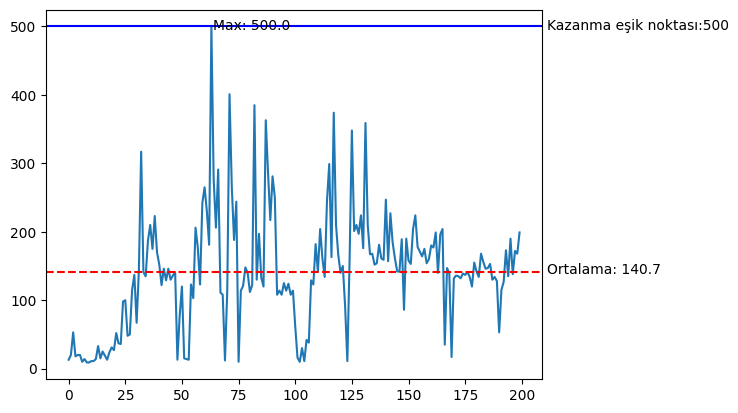

time: 2h 50min 6s (started: 2025-05-17 17:15:26 +00:00)


In [ ]:
env = gym.make("CartPole-v1")
double_dqnagent = DoubleDQNAgent(env,batch_size=32, learning_rate= 0.005, memory_size= 2000, target_update=5) #hyperparameter tuningden dönen en iyi değerleri kullanalım,
# agent.verbose = True #Uncomment yaparak repaly metodu içindeki print'li kısımların görünmesini sağlayabilirsiniz
printInsideTraining = False # T/F yaparak bu hücre içindeki printlerin görünüp görünmemesini sağlayabilirsiniz
# kodda kalabalık odluğunu düşünüyorsanız ve print'lere gerek duymuyorsanız o satırları silebilirsiniz

train_model(env, double_dqnagent, episodes=200, print_episode=True) #ilk 100 civarında çok hızlı ilerledi, 15 dk gibi, sonra hızlı öğrenmeye başladı ve eğitim süresi uzadı

# Pure tensorflow yaklaşımı

Bizim yazdığımız kodda replay metodu numpy ile vektörize hale getirilerek hızlandırılmıştı. Bunun daha da hızlı yolu tensorlarla çalışmak. Bunun için pure python ile yazılmış gymnasium environment'ının tensorflowcasını kullanmak gerekiyor, yani gymanisum environmentları uygun tf wrapperlarla tensorflowlaştırılıyor.

Bunu biz burada kodlamak yerine işi üstadlara bırakalım, [buradan](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial) erişebilirsiniz.